Title: **Innovation or Inequality: Do Patent Litigations Lead to Exacerbated Wealth Inequality?**

Section - 1: Introduction




Section - 2: Data Cleaning and Loading

In [11]:
#importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stargazer

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Loading CSV files

#assigned data set: Patent Litigations
cases = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/cases.csv")

#y-variable from extternal sourc:e
gini = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/Gini.csv")

#3 new x-variables from external soruces:
urbanization = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/urbanization_rate.csv", on_bad_lines='skip')
unemployment = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/US-Unemployment.csv", on_bad_lines='skip')
inflation= pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/inflation.csv", header=0,on_bad_lines='skip')

In [5]:
#isolating relevant variables from the raw litigations data
clean_cases = cases[['case_row_id', 'case_number', 'case_cause', 'date_filed', 'date_closed']]
clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


#aggregating cases filed/closed by year
cases_closed = clean_cases.groupby('year_closed')['case_number'].nunique().reset_index()
cases_closed.columns = ['year', 'cases_closed']
cases_filed = clean_cases.groupby('year_filed')['case_number'].nunique().reset_index()
cases_filed.columns = ['year', 'cases_filed']

#new df containing total cases filed/closed in a given year
annual_cases = pd.merge(cases_filed, cases_closed, on='year', how='outer').fillna(0)
annual_cases[['cases_filed', 'cases_closed']] = annual_cases[['cases_filed', 'cases_closed']].astype(float)
annual_cases['year'] = annual_cases['year'].astype(int)

#cleaning unemployment df and computing avg annual unemployment rates for the US
unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int)
clean_unemployment = pd.DataFrame()
clean_unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int).unique()
clean_unemployment['unemployment_rate'] = (unemployment.groupby(unemployment['observation_date'].str[0:4].astype(int))['UNRATE'].mean().values)

#isolating annual gini coeff data for the US
clean_gini = pd.DataFrame()
clean_gini['year'] = gini['observation_date'].str[0:4].astype(int)
clean_gini['gini'] = gini['SIPOVGINIUSA']

#converting year columns to rows in clean_urbanization df
clean_urbanization = urbanization.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Urban Rate')

clean_urbanization['year'] = pd.to_numeric(clean_urbanization['year'], errors='coerce')
clean_urbanization = clean_urbanization.dropna(subset=['year'])
clean_urbanization['year'] = clean_urbanization['year'].astype(int)
#isolating US data
clean_urbanization = clean_urbanization[clean_urbanization['Country Name'] == 'United States']
clean_urbanization = clean_urbanization.drop(columns=['Country Name'])
clean_urbanization = clean_urbanization.reset_index()


#converting year columns to rows in clean_inflation df
clean_inflation = inflation.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Inflation Rate')

clean_inflation['year'] = pd.to_numeric(clean_inflation['year'], errors='coerce')
clean_inflation = clean_inflation.dropna(subset=['year'])
clean_inflation['year'] = clean_inflation['year'].astype(int)
#isolating US data
clean_inflation = clean_inflation[clean_inflation['Country Name'] == 'United States']
clean_inflation = clean_inflation.drop(columns=['Country Name'])
clean_inflation = clean_inflation.reset_index()

<ipython-input-5-085719f863e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
<ipython-input-5-085719f863e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


In [6]:
#merging all variables into one df
complete_merged = pd.DataFrame()
complete_merged = pd.merge(clean_gini, annual_cases, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_urbanization, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_unemployment, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_inflation, on='year', how='inner')
complete_merged = complete_merged.drop(columns=['index_x'])
complete_merged = complete_merged.drop(columns=['index_y'])

Section - 3: Summary Statistics

In [39]:
from tabulate import tabulate

# Generate summary stats
summary_stats = complete_merged.describe().transpose()

# Add variable descriptions
summary_stats["Description"] = [
    "Year",
    "Gini coefficient (income inequality)",
    "Number of cases filed",
    "Number of cases closed",
    "Unemployment rate (%)",
]
summary_stats = summary_stats[["Description", "mean", "std", "min", "25%", "50%", "75%", "max"]]

# Create a clean ASCII table
print(tabulate(summary_stats, headers="keys", tablefmt="grid"))

+-------------------+--------------------------------------+------------+------------+----------+------------+---------+----------+------------+
|                   | Description                          |       mean |        std |      min |        25% |     50% |      75% |        max |
+===================+======================================+============+============+==========+============+=========+==========+============+
| year              | Year                                 | 1995.84    |   15.1742  | 1963     | 1983.5     | 1996    | 2008.5   | 2021       |
+-------------------+--------------------------------------+------------+------------+----------+------------+---------+----------+------------+
| gini              | Gini coefficient (income inequality) |   38.9078  |    2.1659  |   34.7   |   37.3     |   40    |   40.7   |   41.5     |
+-------------------+--------------------------------------+------------+------------+----------+------------+---------+----------

# New section

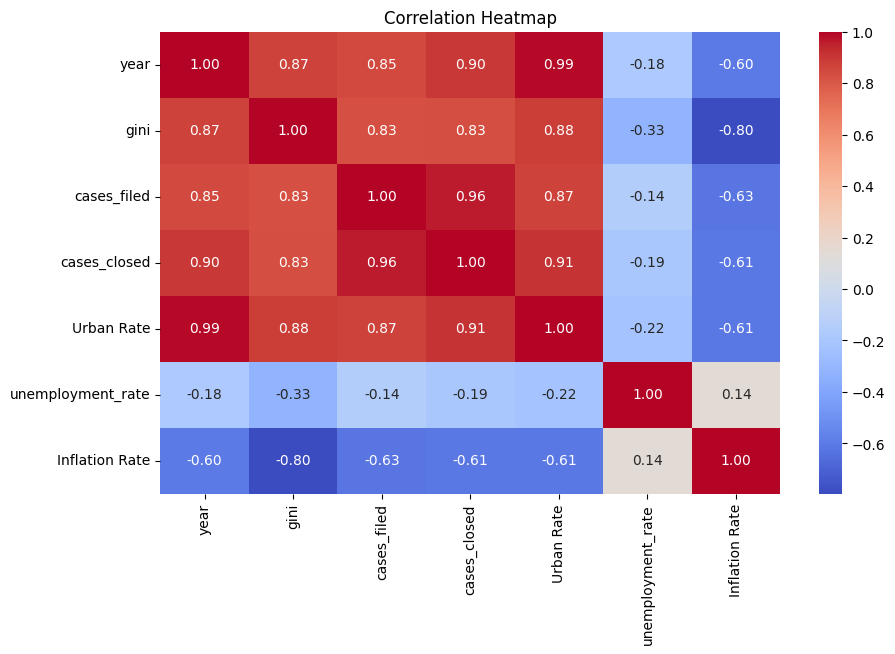

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(complete_merged.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [7]:
complete_merged.describe()

,year,gini,cases_filed,cases_closed,unemployment_rate
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1995.843137,38.907843,1777.725490,1808.215686,6.261928
std,15.174152,2.165903,1686.979052,1773.992022,1.573508
min,1963.000000,34.700000,0.000000,0.000000,3.675000
25%,1983.500000,37.300000,52.500000,10.000000,5.170833
50%,1996.000000,40.000000,1606.000000,1602.000000,5.850000
75%,2008.500000,40.700000,2722.000000,2774.500000,7.275000
max,2021.000000,41.500000,5742.000000,6020.000000,9.708333


Section - 4: Data Visualizations

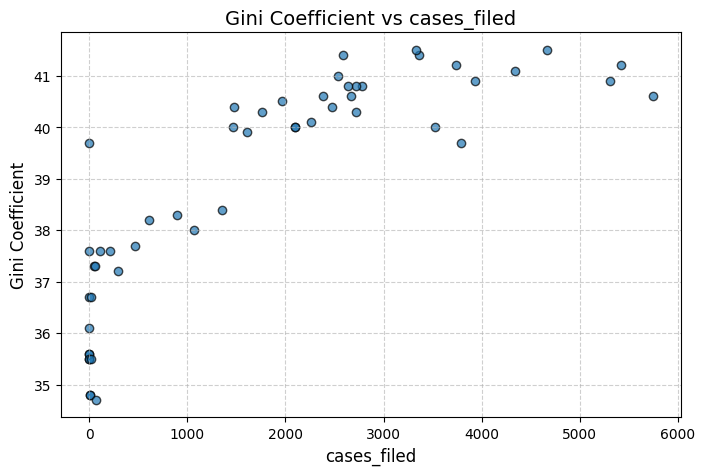

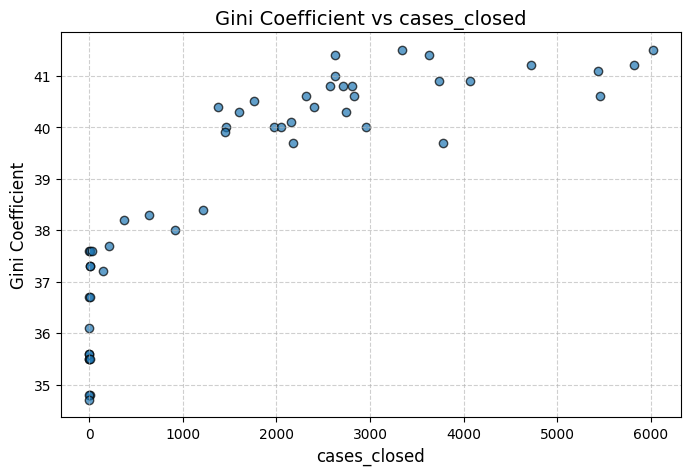

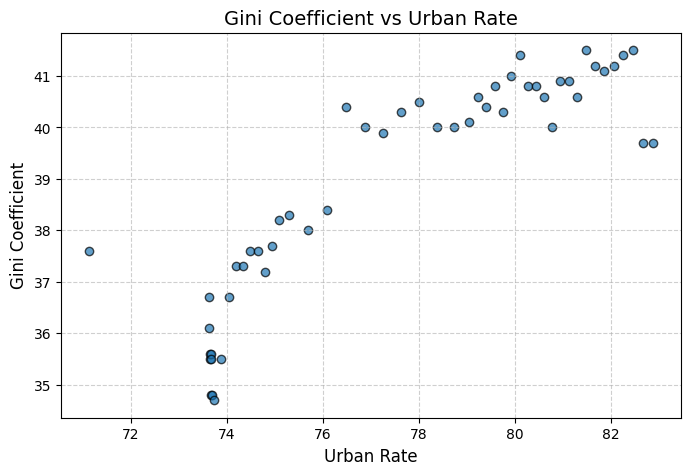

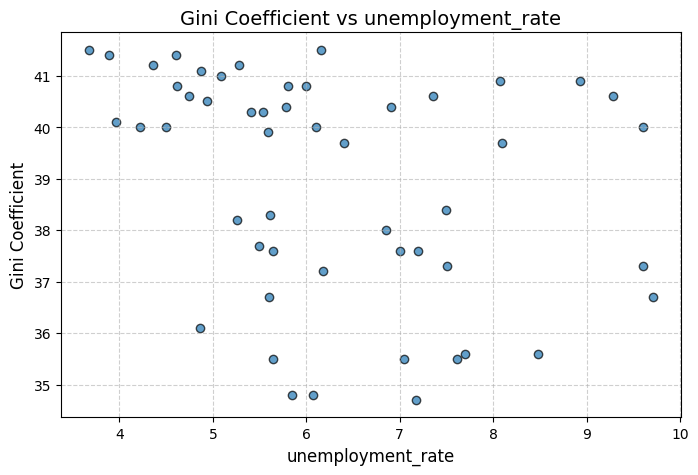

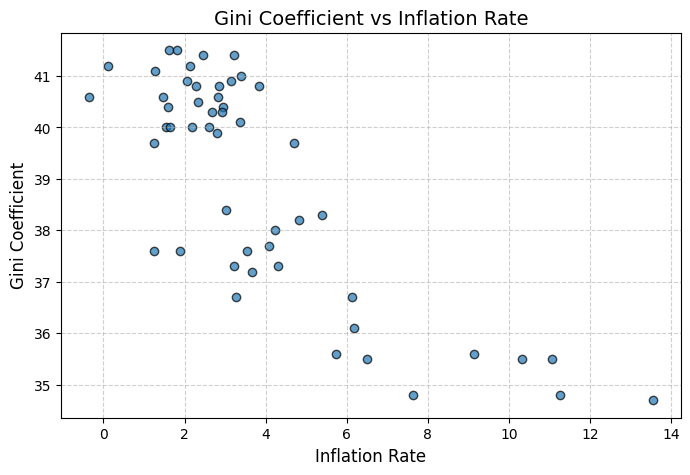

In [8]:
x_vars = ['cases_filed', 'cases_closed', 'Urban Rate', 'unemployment_rate', 'Inflation Rate']

# Loop through each variable and create a scatter plot with Gini
for x in x_vars:
    plt.figure(figsize=(8, 5))
    plt.scatter(complete_merged[x], complete_merged['gini'], alpha=0.7, edgecolor='k')
    plt.title(f'Gini Coefficient vs {x}', fontsize=14)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('Gini Coefficient', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Section - 5: Conclusion

In [69]:
cases['demand'].notna().count()

96966

In [85]:
cases

,case_row_id,case_number,case_number_raw,district_id,court_name,pacer_id,case_name,assigned_to,referred_to,case_cause,...,date_last_filed,jury_demand,demand,lead_case,related_case,settlement,case_type_1,case_type_2,case_type_3,case_type_note
0,78028.0,4:92-cv-00055,4:92-cv-00055-JWS,akd,Alaska District Court,5408.0,"Melba Creek Mining, Inc. et al v. Sykes et al",Judge John W Sedwick,NaN,No cause code entered,...,1992-12-22,Defendant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75332.0,2:10-cv-00601,2:10-cv-00601-WKW-TFM,almd,Middle District of Alabama,43636.0,Bowhall v. Johnson & Johnson Inc. et al (MAG+),Honorable William Keith Watkins,Honorable Terry F. Moorer,15:1126 Patent Infringement,...,2011-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6908.0,1:98-cv-00596,1:98-cv-00596-RBP,alnd,Northern District of Alabama,5576.0,Mettke v. Touchnet Information,Judge Robert B Propst,NaN,35:183 Patent Infringement,...,1998-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6933.0,1:98-cv-00654,1:98-cv-00654-CB-C,alsd,Southern District of Alabama,27451.0,"Monsanto Co. Inc. v. Styron, et al","Senior Judge Charles R. Butler, Jr",Magistrate Judge William E. Cassady,28:1338 Patent Infringement,...,1999-03-15,Defendant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86730.0,1:18-cv-00012,1:18-cv-00012-BRW,ared,Eastern District of Arkansas,110647.0,Sundesa LLC v. Eurark LLC,Judge Billy Roy Wilson,NaN,35:271 Patent Infringement,...,2018-07-06,Both,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96961,29713.0,2:97-cv-00019,2:97-cv-00019-ABJ,wyd,Wyoming District Court,8221.0,Chey Land & Cattle v. Crown Cork & Seal Co,Honorable Alan B Johnson,NaN,35:271 Patent Infringement,...,1997-07-25,Plaintiff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96962,39890.0,2:11-cv-00352,2:11-cv-00352-SWS,wyd,Wyoming District Court,23426.0,Weir Minerals Australia Ltd v. Megatrol Inc et al,Honorable Scott W Skavdahl,Honorable Scott W Skavdahl,35:271 Patent Infringement,...,2012-11-15,Both,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
96963,104380.0,2:15-cv-00149,2:15-cv-00149-ABJ,wyd,Wyoming District Court,33849.0,Kims Kreations Inc v. Walt Disney Company,Judge Alan B Johnson,Honorable Kelly H Rankin,28:1331 Fed. Question: Trademark,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96964,37186.0,2:08-cv-00045,2:08-cv-00045-WFD,wyd,Wyoming District Court,17465.0,Retractable Technologies LLC v. RadioShack Cor...,Judge William F Downes,Judge William C Beaman,35:271 Patent Infringement,...,2009-07-20,Both,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [93]:
attorneys = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/attorneys.csv")
patents = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/patents.csv")
documents = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/documents.csv")

<ipython-input-93-2542bd539208>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  documents = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/documents.csv")


In [92]:
documents

,case_type_1
0,NaN
1,2.0
2,1.0
3,1.0
4,1.0
...,...
159396,1.0
159397,1.0
159398,1.0
159399,1.0
